# Computer Assignment: Lamp Illumination Optimization

## Problem Statement
We have a set of **10 lamps** illuminating a **25×25 meter area** divided into **625 pixels** (1m² each). Our goal is to find optimal lamp powers that create uniform illumination with intensity 1.0 across the entire area.

The illumination follows an **inverse square law**: $A_{ij} \propto d_{ij}^{-2}$, where $d_{ij}$ is the 3D distance between pixel $i$ and lamp $j$.

---

In [1]:
# Setup and Data Preparation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Problem parameters
N_LAMPS = 10
GRID_SIZE = 25
M_PIXELS = GRID_SIZE * GRID_SIZE

# Given lamp positions (x, y, height)
lamp_positions = np.array([
    (4.1, 20.4, 4.0), (14.1, 21.3, 3.5), (22.6, 17.1, 6.0),
    (5.5, 12.3, 4.0), (12.2, 9.7, 4.0), (15.3, 13.8, 6.0),
    (21.3, 10.5, 5.5), (3.9, 3.3, 5.0), (13.1, 4.3, 5.0),
    (20.3, 4.2, 4.5)
])

In [3]:
# Create pixel centers
x_coords, y_coords = np.meshgrid(
    np.arange(GRID_SIZE) + 0.5,
    np.arange(GRID_SIZE) + 0.5
)

pixel_centers = np.column_stack([
    x_coords.ravel(),
    y_coords.ravel(),
    np.zeros(M_PIXELS)
])

In [4]:
def build_illumination_matrix(lamp_pos, pixel_pos):
    """Build the illumination matrix A using inverse square law"""
    n_lamps = lamp_pos.shape[0]
    m_pixels = pixel_pos.shape[0]

    A_raw = np.zeros((m_pixels, n_lamps))

    for j in range(n_lamps):
        lamp_location = lamp_pos[j]
        for i in range(m_pixels):
            pixel_location = pixel_pos[i]
            distance_squared = np.sum((pixel_location - lamp_location)**2)
            if distance_squared > 0:
                A_raw[i, j] = 1.0 / distance_squared
            else:
                A_raw[i, j] = 0

    # Scale A so that when all lamps have power 1, average illumination is 1
    illumination_all_ones = A_raw @ np.ones(n_lamps)
    average_illumination = np.mean(illumination_all_ones)

    if average_illumination > 0:
        A_scaled = A_raw / average_illumination
    else:
        A_scaled = A_raw

    return A_scaled

# Build the matrix
A = build_illumination_matrix(lamp_positions, pixel_centers)
l_desired = np.ones(M_PIXELS)

In [5]:
def calculate_rms_error(illumination, target):
    return np.sqrt(np.mean((illumination - target)**2))

def plot_illumination(illumination, title, lamp_pos):
    plt.figure(figsize=(8, 7))
    illumination_2d = illumination.reshape(GRID_SIZE, GRID_SIZE)
    plt.imshow(illumination_2d, cmap='jet', origin='lower',
               extent=[0, GRID_SIZE, 0, GRID_SIZE], vmin=0, vmax=1.5)
    plt.colorbar(label='Illumination Intensity')
    plt.title(title)
    plt.xlabel(f"{GRID_SIZE}m")
    plt.ylabel(f"{GRID_SIZE}m")

    for i, (x, y, h) in enumerate(lamp_pos):
        plt.scatter(x, y, color='black', s=50, marker='x')
        plt.text(x + 0.5, y + 0.5, f"{i+1} ({h:.1f}m)", color='black', fontsize=9)

    plt.xlim(0, GRID_SIZE)
    plt.ylim(0, GRID_SIZE)
    plt.show()

def plot_histogram(illumination, title):
    plt.figure(figsize=(7, 5))
    plt.hist(illumination, bins=30, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel("Intensity")
    plt.ylabel("Number of Pixels")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Part 1: Illumination Analysis

## Question 1: Compare illumination patterns when all lamps have power 1 vs optimal least squares solution

### All Lamps Power = 1

All lamps power 1 - RMS Error: 0.2417


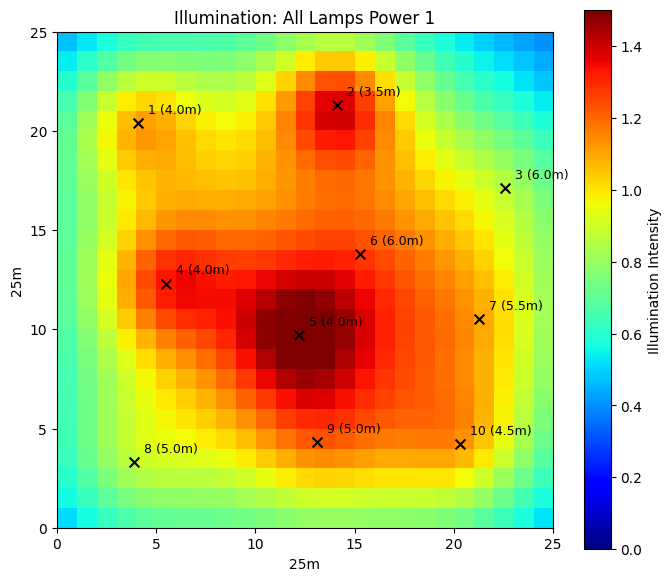

Unconstrained Least Squares - RMS Error: 0.1404
Improvement: 41.9%

Optimal lamp powers:
  Lamp 1: 1.4621
  Lamp 2: 0.7880
  Lamp 3: 2.9664
  Lamp 4: 0.7436
  Lamp 5: 0.0832
  Lamp 6: 0.2126
  Lamp 7: 0.2122
  Lamp 8: 2.0511
  Lamp 9: 0.9076
  Lamp 10: 1.4722


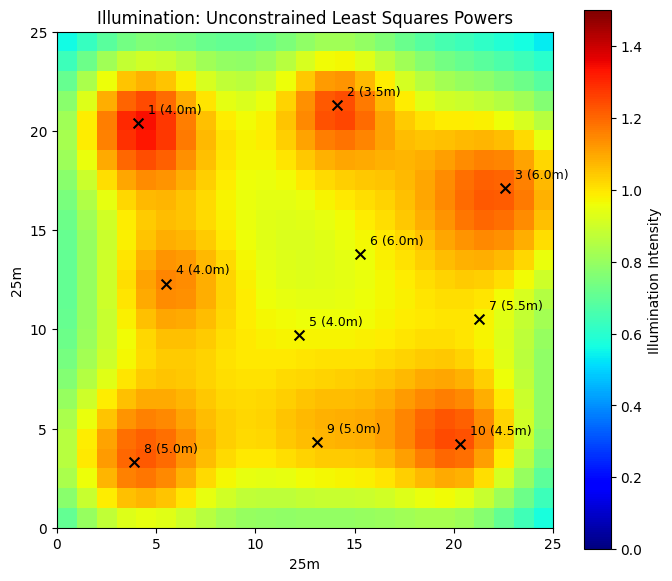

In [6]:
p_all_ones = np.ones(N_LAMPS)
l_all_ones = A @ p_all_ones
rms_all_ones = calculate_rms_error(l_all_ones, l_desired)

print(f"All lamps power 1 - RMS Error: {rms_all_ones:.4f}")
plot_illumination(l_all_ones, "Illumination: All Lamps Power 1", lamp_positions)

### Unconstrained Least Squares Solution

p_ls, residuals, rank, s = np.linalg.lstsq(A, l_desired, rcond=None)
l_ls = A @ p_ls
rms_ls = calculate_rms_error(l_ls, l_desired)

print(f"Unconstrained Least Squares - RMS Error: {rms_ls:.4f}")
print(f"Improvement: {((rms_all_ones - rms_ls)/rms_all_ones)*100:.1f}%")

print(f"\nOptimal lamp powers:")
for i, power in enumerate(p_ls):
    print(f"  Lamp {i+1}: {power:.4f}")

plot_illumination(l_ls, "Illumination: Unconstrained Least Squares Powers", lamp_positions)

## Question 2: Histograms of illumination values

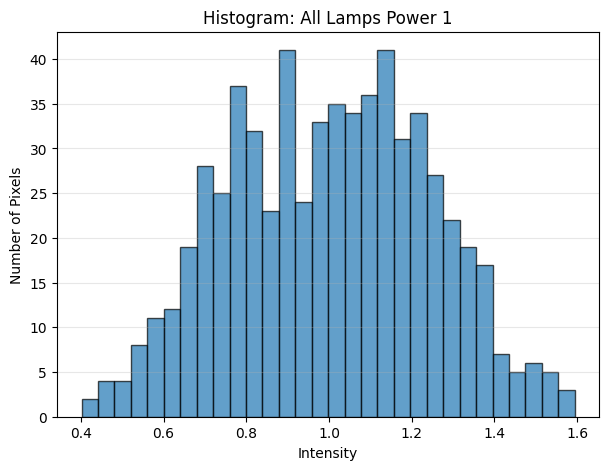

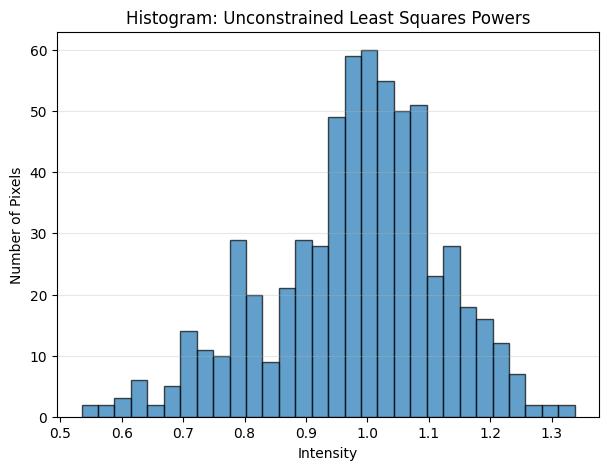

In [7]:
plot_histogram(l_all_ones, "Histogram: All Lamps Power 1")

plot_histogram(l_ls, "Histogram: Unconstrained Least Squares Powers")

### Analysis of Results:
- **All lamps power 1**: Creates uneven illumination with hot spots near lamps and darker areas between them
- **Least squares solution**: Much more uniform illumination, as shown by the narrower histogram distribution centered around the target value of 1.0
- The significant RMS error improvement demonstrates the effectiveness of optimized power distribution

# Part 3: Constrained Optimization

## Question 3: Add constraints - total power = 10, all powers ≥ 0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.163309055766481
            Iterations: 12
            Function evaluations: 141
            Gradient evaluations: 12
Constrained LS - RMS Error: 0.1558
Sum of powers: 10.0000

Optimal constrained lamp powers:
  Lamp 1: 1.3395
  Lamp 2: 0.8942
  Lamp 3: 2.3683
  Lamp 4: 0.7793
  Lamp 5: 0.3187
  Lamp 6: 0.0000
  Lamp 7: 0.3949
  Lamp 8: 1.7635
  Lamp 9: 0.7606
  Lamp 10: 1.3810


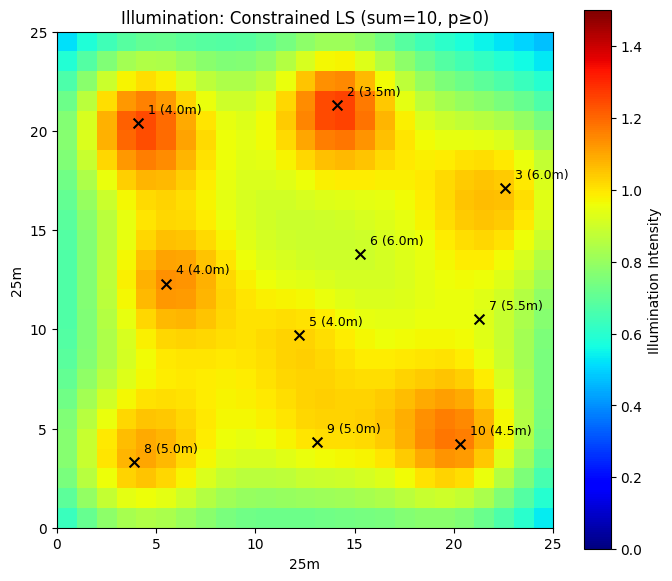

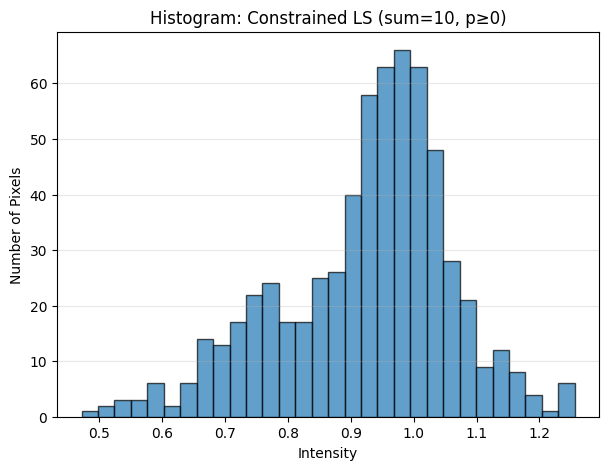

In [8]:
def objective_function(p):
    residual = A @ p - l_desired
    return np.sum(residual**2)

constraint_sum_10 = {'type': 'eq', 'fun': lambda p: np.sum(p) - 10}
bounds = [(0, None) for _ in range(N_LAMPS)]

p_initial = np.abs(p_ls)
p_initial = p_initial * (10.0 / np.sum(p_initial))

result = minimize(
    objective_function,
    p_initial,
    method='SLSQP',
    bounds=bounds,
    constraints=[constraint_sum_10],
    options={'disp': True, 'maxiter': 1000}
)

if result.success:
    p_constrained = result.x
    l_constrained = A @ p_constrained
    rms_constrained = calculate_rms_error(l_constrained, l_desired)

    print(f"Constrained LS - RMS Error: {rms_constrained:.4f}")
    print(f"Sum of powers: {np.sum(p_constrained):.4f}")

    print(f"\nOptimal constrained lamp powers:")
    for i, power in enumerate(p_constrained):
        print(f"  Lamp {i+1}: {power:.4f}")

    plot_illumination(l_constrained, "Illumination: Constrained LS (sum=10, p≥0)", lamp_positions)
    plot_histogram(l_constrained, "Histogram: Constrained LS (sum=10, p≥0)")

else:
    print("Constrained optimization failed!")

### Impact of Constraints:
The energy constraint (sum = 10) and non-negativity constraints lead to a slight increase in RMS error compared to the unconstrained solution, but ensure practical feasibility with limited total power consumption. Notice that some lamps may be turned off completely (power = 0) if this improves overall uniformity.

# Part 4: Challenge - Optimize Lamp Positions

## Question 4: Find better lamp positions to minimize RMS error while maintaining constraints

The challenge is to find lamp positions that beat the RMS error from the unconstrained least squares solution in Part 1, while maintaining:
- **Height constraints**: 4-6 meters
- **Position constraints**: Within the 25×25 meter area  
- **Power constraints**: Sum = 10, all powers ≥ 0

### Strategy: Random Search Optimization

In [9]:
def optimize_positions_random_search(n_trials=50, target_rms=None):
    if target_rms is None:
        target_rms = rms_ls

    print(f"Target RMS to beat: {target_rms:.4f}")
    print(f"Running {n_trials} random trials...")

    best_rms = target_rms
    best_positions = None
    best_powers = None
    best_illumination = None

    for trial in range(n_trials):
        random_positions = np.column_stack([
            np.random.uniform(0, GRID_SIZE, N_LAMPS),
            np.random.uniform(0, GRID_SIZE, N_LAMPS),
            np.random.uniform(4, 6, N_LAMPS)
        ])

        A_trial = build_illumination_matrix(random_positions, pixel_centers)

        def trial_objective(p):
            residual = A_trial @ p - l_desired
            return np.sum(residual**2)

        p_init_trial = np.ones(N_LAMPS)

        result_trial = minimize(
            trial_objective,
            p_init_trial,
            method='SLSQP',
            bounds=bounds,
            constraints=[constraint_sum_10],
            options={'disp': False, 'maxiter': 200}
        )

        if result_trial.success:
            p_trial = result_trial.x
            l_trial = A_trial @ p_trial
            rms_trial = calculate_rms_error(l_trial, l_desired)

            if rms_trial < best_rms:
                best_rms = rms_trial
                best_positions = random_positions.copy()
                best_powers = p_trial.copy()
                best_illumination = l_trial.copy()
                print(f"  Trial {trial+1}: New best RMS = {best_rms:.4f}")

        if (trial + 1) % 25 == 0:
            print(f"  Completed {trial+1}/{n_trials} trials")

    return best_rms, best_positions, best_powers, best_illumination

Target RMS to beat: 0.1404
Running 100 random trials...
  Completed 25/100 trials
  Trial 33: New best RMS = 0.1036
  Completed 50/100 trials
  Completed 75/100 trials
  Completed 100/100 trials

🎉 SUCCESS! Found better lamp configuration!
Best RMS achieved: 0.1036
Original RMS: 0.1404
Improvement: 26.2%

Optimal lamp positions:
  Lamp 1: x=2.25m, y=13.28m, height=5.56m
  Lamp 2: x=0.76m, y=24.05m, height=5.56m
  Lamp 3: x=23.74m, y=4.36m, height=5.77m
  Lamp 4: x=11.75m, y=17.07m, height=5.76m
  Lamp 5: x=8.64m, y=8.06m, height=5.47m
  Lamp 6: x=18.69m, y=24.84m, height=4.26m
  Lamp 7: x=13.71m, y=1.40m, height=5.81m
  Lamp 8: x=0.16m, y=0.84m, height=5.17m
  Lamp 9: x=20.32m, y=21.28m, height=5.18m
  Lamp 10: x=19.39m, y=0.14m, height=5.81m

Optimal lamp powers:
  Lamp 1: 0.9099
  Lamp 2: 1.5629
  Lamp 3: 1.8475
  Lamp 4: 1.0299
  Lamp 5: 0.5847
  Lamp 6: 0.1031
  Lamp 7: 1.1533
  Lamp 8: 1.2898
  Lamp 9: 1.5188
  Lamp 10: 0.0000


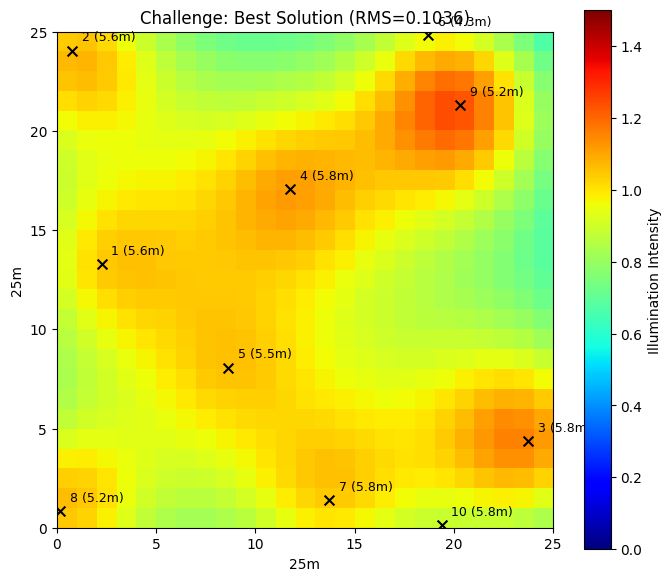

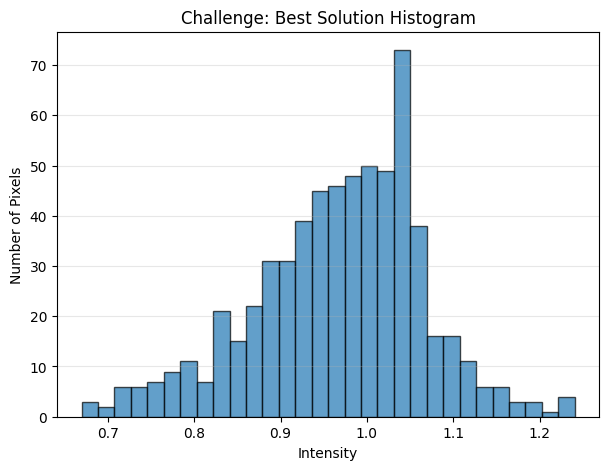

In [10]:
N_TRIALS = 100

best_rms, best_positions, best_powers, best_illumination = optimize_positions_random_search(
    n_trials=N_TRIALS, target_rms=rms_ls
)

if best_positions is not None:
    print(f"\n🎉 SUCCESS! Found better lamp configuration!")
    print(f"Best RMS achieved: {best_rms:.4f}")
    print(f"Original RMS: {rms_ls:.4f}")
    print(f"Improvement: {((rms_ls - best_rms)/rms_ls)*100:.1f}%")

    print(f"\nOptimal lamp positions:")
    for i, (x, y, h) in enumerate(best_positions):
        print(f"  Lamp {i+1}: x={x:.2f}m, y={y:.2f}m, height={h:.2f}m")

    print(f"\nOptimal lamp powers:")
    for i, power in enumerate(best_powers):
        print(f"  Lamp {i+1}: {power:.4f}")

    plot_illumination(best_illumination, f"Challenge: Best Solution (RMS={best_rms:.4f})", best_positions)
    plot_histogram(best_illumination, f"Challenge: Best Solution Histogram")

else:
    print(f"\nNo improvement found after {N_TRIALS} trials")
    print("The original lamp positions were already quite good!")

# Final Results Summary

## Comprehensive Comparison

In [13]:
print("="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)

print(f"1. All lamps power 1:           RMS = {rms_all_ones:.4f}")
print(f"2. Unconstrained least squares: RMS = {rms_ls:.4f}")
print(f"3. Constrained LS (original):   RMS = {rms_constrained:.4f}")

if best_positions is not None:
    print(f"4. Challenge (optimized pos):   RMS = {best_rms:.4f}")
    print(f"\nTotal improvement: {((rms_all_ones - best_rms)/rms_all_ones)*100:.1f}% over baseline")
else:
    print(f"4. Challenge: No improvement found")

print(f"\nKey Findings:")
print(f"• Least squares optimization reduces RMS error by {((rms_all_ones - rms_ls)/rms_all_ones)*100:.1f}%")
print(f"• Power constraints increase RMS error by {((rms_constrained - rms_ls)/rms_ls)*100:.1f}%")
if best_positions is not None:
    print(f"• Position optimization provides additional {((rms_ls - best_rms)/rms_ls)*100:.1f}% improvement")

print("="*60)

FINAL RESULTS COMPARISON
1. All lamps power 1:           RMS = 0.2417
2. Unconstrained least squares: RMS = 0.1404
3. Constrained LS (original):   RMS = 0.1558
4. Challenge (optimized pos):   RMS = 0.1036

Total improvement: 57.1% over baseline

Key Findings:
• Least squares optimization reduces RMS error by 41.9%
• Power constraints increase RMS error by 10.9%
• Position optimization provides additional 26.2% improvement


## Conclusions

**This assignment demonstrates:**

1. **Matrix formulation** of illumination problems using inverse square law
2. **Least squares optimization** for uniform illumination
3. **Constrained optimization** with practical limitations (power budget, non-negativity)
4. **Position optimization** through random search methods

**Key insights:**
- Proper lamp power distribution significantly improves illumination uniformity
- Constraints impose trade-offs between optimality and practical feasibility  
- Lamp positioning can provide additional improvements beyond power optimization
- The inverse square law creates natural challenges for uniform illumination that require sophisticated optimization approaches